<a href="https://colab.research.google.com/github/serg-kas/NN-archive/blob/main/%D0%90%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_2020_Light_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_22_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Импорт библиотек

In [ ]:
import numpy as np 
import pandas as pd 

from tensorflow.keras.models import Model, Sequential         #модели
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate   #слои
from tensorflow.keras.layers import Activation, MaxPooling2D, Conv2D, BatchNormalization, Dropout           #слои
from tensorflow.keras import backend as K                     #базовые керасовские функции
from tensorflow.keras.optimizers import Adam                  #оптимизатор
from tensorflow.keras import utils                            #утилиты 
from tensorflow.keras.datasets import mnist, fashion_mnist    #готовые базы mnist

from sklearn.model_selection import train_test_split          #модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler              #модуль для стандартизации данных
from tensorflow.keras.preprocessing import image              #модуль для отрисовки изображения

import matplotlib.pyplot as plt
from PIL import Image                                         #модуль для отрисовки изображения

import time

import os 
from google.colab import drive 


In [ ]:
# Монтируем google диск
drive.mount('/content/drive/') 

Mounted at /content/drive/


##Light

**Вариант 1**

Перепишите ***автокодировщик для базы лиц*** “с нуля”, в новом ноутбуке. Можно подсматривать в ноутбук в занятия, но крайне желательно писать код своими руками, а не копировать



In [ ]:
# Распаковываем базу с лицами с google диска в colaboratory

!unzip -q '/content/drive/My Drive/my_sample_data/Д.З.22/Лица.zip' 


images_dir = 'Лица'    #имя папки в которую распоковали изображения

img_height = 112       #зададим высоту изображений
img_width = 80         #зададим ширину избражений


In [ ]:
#ОПРЕДЕНИЕ ФУНКЦИЙ

# Функция загрузки изображений. На вход принимает имя папки с изображениями и 
# высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width):

  list_images = []      #пустой список для храния изображений
  
  for img in os.listdir(images_dir): 
  # добавим в список изображение в виде массива
  # заданного размера и в оттенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), \
                                                         target_size=(img_height, img_width), \
                                                         color_mode='grayscale')))

  return np.array(list_images)  #возвращаем numpy массив загруженных избражений


# Функция отрисовки картинок из массивов
def plotImages(xTrain, pred, shape=(img_height, img_width)): 

  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(10, 4)) # указываем размеры фигуры

  for i in range(n): 
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()


# Функция создания базового автокодировщика
def baseAutoencoder(shape=(img_height, img_width, 1)):

    img_input = Input((shape))                                             #входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)   #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)           #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных 
    x = MaxPooling2D()(x)                                                  #подвыборка, снижающий размерность

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)           #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)           #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных
    z = MaxPooling2D()(x)                                                  #подвыборка = Z
    
    #слой разжимает данные(с 28*20 на 56*40)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
    x = BatchNormalization()(x)                                            #нормализация данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)           #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)           #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных
    
    #слой разжимает данные(с 56*40 на 112*80)
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)                                            #нормализация данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)           #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)           #двумерная свертка
    x = BatchNormalization()(x)                                            #нормализация данных

    #финальный слой двумерной свертки
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)                    #создаем модель с изображением на входе
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error')       #компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model    #возвращаем откомпилированную модель


# Функция вычисление среднеквадратической ошибки
def getMSE(x1, x2):
  
  x1 = x1.flatten()  #сплющиваем в одномерный вектор
  x2 = x2.flatten()  #сплющиваем в одномерный вектор
  delta = x1 - x2    #находим разницу
  
  return sum(delta ** 2) / len(delta)   #возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# Загружаем изображения в массив из папки, посмотрим размерность и сразу нормируем данные

cur_time = time.time()  #засечем время

# Загружаем избражения
xTrain_img = load_images(images_dir, img_height, img_width)   

print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')
print('Загрузили массив изображений размерностью: ', xTrain_img.shape)

# Нормируем данные изображения к диапазону от 0 до 1
xTrain_img = xTrain_img / 255 


Время загрузки: 33.56с
Загрузили массив изображений размерностью:  (5018, 112, 80, 1)


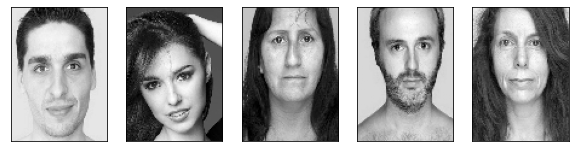

In [ ]:
# Посмотрим несколько случайных изображений
plt.figure(figsize=(10, 4))
for  i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(img_height, img_width), cmap='gray') 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Создаем автокодировщик с помощью предварительно определенной функции

modelAutoFace = baseAutoencoder() 

# берём первые 4700 картинок из xTrain_img и на вход, и на выход, 
# в качестве проверочной берем оставшиеся из xTrain_img

modelAutoFace.fit(xTrain_img[:4700], xTrain_img[:4700], \
                  epochs=150, \
                  batch_size=100, \
                  validation_data = (xTrain_img[4700:], xTrain_img[4700:]))



Epoch 1/150
47/47 [==============================] - 8s 169ms/step - loss: 0.0437 - val_loss: 0.0674
Epoch 2/150
47/47 [==============================] - 8s 165ms/step - loss: 0.0120 - val_loss: 0.0673
Epoch 3/150
47/47 [==============================] - 8s 166ms/step - loss: 0.0077 - val_loss: 0.0661
Epoch 4/150
47/47 [==============================] - 8s 166ms/step - loss: 0.0060 - val_loss: 0.0636
Epoch 5/150
47/47 [==============================] - 8s 168ms/step - loss: 0.0051 - val_loss: 0.0588
Epoch 6/150
47/47 [==============================] - 8s 168ms/step - loss: 0.0045 - val_loss: 0.0519
Epoch 7/150
47/47 [==============================] - 8s 169ms/step - loss: 0.0042 - val_loss: 0.0429
Epoch 8/150
47/47 [==============================] - 8s 170ms/step - loss: 0.0040 - val_loss: 0.0324
Epoch 9/150
47/47 [==============================] - 8s 171ms/step - loss: 0.0037 - val_loss: 0.0236
Epoch 10/150
47/47 [==============================] - 8s 172ms/step - loss: 0.0035 - val_lo

In [ ]:
# Сохраним веса

#modelAutoFace.save_weights('/content/drive/My Drive/my_sample_data/Д.З.22/modelAutoFace.h5')
modelAutoFace.load_weights('/content/drive/My Drive/my_sample_data/Д.З.22/modelAutoFace.h5')

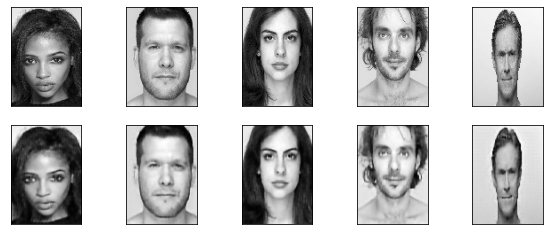

In [ ]:
# Сделаем предикт для первых ста картинок лиц
predFace = modelAutoFace.predict(xTrain_img[:100]) 

# Пересчитаем результат в диапазон от 0 до 255
predFace = predFace * 255 
# Устанавливаем 8битовый тип
predFace = predFace.astype('uint8') 

# И выведем оригинальные и сгенерированные автокодировщиком картинки
plotImages(xTrain_img, predFace) 

In [ ]:
# Выведем среднеквадратические ошибки 

errFace = [getMSE(xTrain_img[i], predFace[i] / 255) for i in range(len(predFace))]     #посчитаем ошибку для всех изображений

print("Ошибка на Лицах:", errFace[80:])                                                #посмотрим последнии 20
print("Средняя ошибка на Лицах:", round(sum(errFace[80:]) / len(errFace[80:]), 4))     #посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Лицах:", round(min(errFace),4))                           #найдем минимальную ошибку


Ошибка на Лицах: [0.0014526248633027303, 0.000776473449733281, 0.00043269763147660024, 0.0007930655476082658, 0.0005661063462889143, 0.001234353640101543, 0.0006844124722377996, 0.0009792457744217946, 0.000894173665632202, 0.0008444694447793293, 0.00044621060469754117, 0.0006301355702184673, 0.00174538314341775, 0.0007962066470714753, 0.0007773608595622973, 0.0009645536967420593, 0.0012099210990266748, 0.0022142138903206514, 0.0008157887073849016, 0.0009308389653108903]
Средняя ошибка на Лицах: 0.001
Минимальная ошибка на Лицах: 0.0004


In [ ]:
bias = 0.005 # установим какое-то пороговое значение

isFace = [e < bias for e in errFace[80:]] # запишем каждую ошибку больше порогового значения

print("Лица распознаны, как Лица: ", round(100*sum(isFace) / len(isFace)),"%", sep="")

Лица распознаны, как Лица: 100.0%


**На этом задание Light1 восстановить автокодировщик лиц из вебинара выполнено.** 

**Ниже я еще поиграюсь восстановлением зашумленных картинок.**

In [ ]:
# Определим функцию добавления шума
# noiseVal - переменная "усилитель шума"

def addNoise(x, noiseVal): 

  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  return np.clip(x + noiseVal * noise, 0., 1.) 

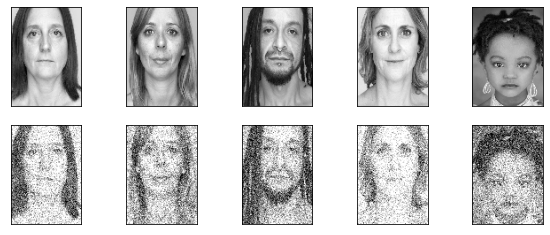

In [ ]:
# Создадим зашумленный вариант лиц и выведем примеры на экран
noisedXTrainFace = addNoise(xTrain_img, 0.4) # cоздаем зашумленный вариант лиц из xTrain_img

plotImages(xTrain_img, noisedXTrainFace) 

In [ ]:
# Функция создания автокодировщика для подавления шума

def denoiseAutoencoder(): 
    img_input = Input((img_height, img_width, 1)) 

    # Добавляем четыре сверточных слоя, вместо MaxPooling используем strides
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 7*5*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(7*5*256, activation='relu')(z) # и еще полносвязный слой с переводом в 8960-мерное пространство(7*5*256)
    x = Reshape((7,5,256))(x) # меняем размеры - картинка 7*5 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 7*5 до 14*10
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 14*10 до 28*20
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 28*20 до 56*40
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 56*40 до 112*80
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # и пропускаем через финальный слой двумерной свертки

    model = Model(img_input, x) # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model.compile(optimizer='adam',
                  loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return model # функция вернет модель подавления шума

In [ ]:
# Создаем и обучаем модель
modelDenoiseFace = denoiseAutoencoder()
# Подаем на вход зашумленные картинки, а на выход правильные
modelDenoiseFace.fit(noisedXTrainFace[:4700], xTrain_img[:4700], \
                     epochs=80, \
                     batch_size=100, \
                     validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]))

Epoch 1/80
47/47 [==============================] - 4s 79ms/step - loss: 0.0581 - val_loss: 0.0406
Epoch 2/80
47/47 [==============================] - 3s 73ms/step - loss: 0.0277 - val_loss: 0.0198
Epoch 3/80
47/47 [==============================] - 3s 73ms/step - loss: 0.0171 - val_loss: 0.0152
Epoch 4/80
47/47 [==============================] - 3s 73ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 5/80
47/47 [==============================] - 3s 73ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 6/80
47/47 [==============================] - 3s 74ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 7/80
47/47 [==============================] - 3s 73ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 8/80
47/47 [==============================] - 3s 74ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 9/80
47/47 [==============================] - 3s 74ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 10/80
47/47 [==============================] - 4s 75ms/step - loss: 0.0083 - val_loss: 0.0095
Epoch 11/

In [ ]:
# Сохраняем веса
#modelDenoiseFace.save_weights('/content/drive/My Drive/my_sample_data/Д.З.22/modelDenoiseFace.h5') 
modelDenoiseFace.load_weights('/content/drive/My Drive/my_sample_data/Д.З.22/modelDenoiseFace.h5') 

In [ ]:
# Предикт по 4тыс зашумленных картинок 
predFaceDenoise = modelDenoiseFace.predict(noisedXTrainFace[:4000]) 

# Пересчитаем результат в диапазон от 0 до 255
predFaceDenoise = predFaceDenoise * 255 
# Устанавливаем 8битовый тип
predFaceDenoise = predFaceDenoise.astype('uint8') 

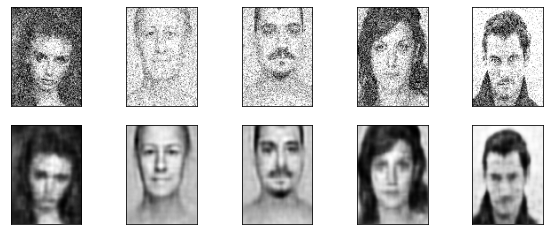

In [ ]:
#Сравним зашумленные и восстановленные картинки
plotImages(noisedXTrainFace, predFaceDenoise) 

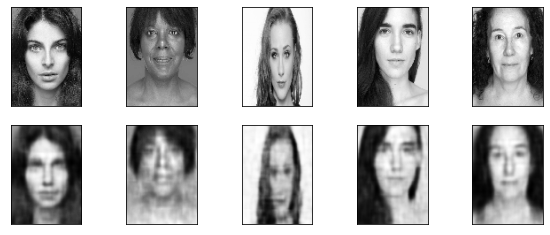

In [ ]:
# Сравним исходные и восстановленные картинки
plotImages(xTrain_img, predFaceDenoise) 

##PRO

**Вариант 1**

Добейтесь точности 93% в задаче ***поиска мошеннических операций***. Для этого попробуйте сделать более мощный автокодировщик и гибкую настройку порога (bias), по которому мы определяем, мошенническая транзакция или нет



In [ ]:
# Читаем базу
df = pd.read_csv("/content/drive/My Drive/my_sample_data/Д.З.22/creditcard.csv") 

In [ ]:
# и смотрим что загрузили
df.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#Начинаем подготовку данных

data = df.drop(['Time'], axis=1)    #удаляем столбец со временем
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))   #нормализуем столбец с суммой транзакции


In [ ]:
#Сохраним операции в новые датасеты и посмотим их размеры

frauds = data[data.Class == 1]    #мошеннические операции
print('Мошеннические операции: ', frauds.shape)

normal = data[data.Class == 0]    #нормальные операции
print('Нормальные операции: ', normal.shape)



Мошеннические операции:  (492, 30)
Нормальные операции:  (284315, 30)


In [ ]:
RANDOM_SEED = 42 # задаем случайное значение

# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# Удаляем класс в обучающем наборе данных
X_train = X_train.drop(['Class'], axis=1)
# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = pd.concat([X_test, frauds])
# Делаем метки для тестового набора данных
y_test = X_test['Class']
# Удаляем класс у тестового набора данных
X_test = X_test.drop(['Class'], axis=1)
# Преобразуем данные в массивы numpy
X_train = X_train.values
X_test = X_test.values


In [ ]:
print(X_train.shape) # взглянем на размеры обучающих данных

(227452, 29)


In [ ]:
 # Функция автокодировщика для определения мошенических транзакций

def creditcardAutoencoder():

  dataSize = X_train.shape[1] # берём размеры X_train по второй оси(30)

  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  #x = Dropout(0.7)(dataInput)
  x = Dense(60, activation='linear')(dataInput) 
  x = Dropout(0.5)(x)
  x = Dense(60, activation='linear')(x)
  x = Dropout(0.5)(x)
  x = Dense(10, activation='linear')(x)
  #x = Dropout(0.5)(x)
  #x = Dense(30, activation='linear')(x)
  #x = Dropout(0.5)(x)
  x = Dense(dataSize, activation='linear')(x) 
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель   
  autoencoder.compile(optimizer='Adam', loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
# Загружаем данные в модель(X_train'ы) и обучаем

model = creditcardAutoencoder()
history = model.fit(X_train, X_train,
                    epochs=1,
                    batch_size=64) 

3554/3554 [==============================] - 7s 2ms/step - loss: 0.6720


In [ ]:
modelDenoiseFace.save_weights('/content/drive/My Drive/my_sample_data/Д.З.22/modelTransaction.h5') 
modelDenoiseFace.load_weights('/content/drive/My Drive/my_sample_data/Д.З.22/modelTransaction.h5')

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test

In [ ]:
mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных трансакций:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных трансакций:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных трансакций:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных трансакций: 0.0445
Максимальная ошибка нормальных трансакций: 544.5062
Средняя ошибка нормальных трансакций: 0.4185


In [ ]:
print("Минимальная ошибка мошеннических трансакций:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических трансакций:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических трансакций:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических трансакций: 0.1674
Максимальная ошибка мошеннических трансакций: 138.9566
Средняя ошибка мошеннических трансакций: 20.3124


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций

  print("Распознано нормальных трансакций: ", round(100*accNormal,1), "%", sep="")
  print("Распознано мошеннических трансакций: ", round(100*accFaruds,1), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accNormal + accFaruds),1), "%", sep="")


In [ ]:
def getAccByBias2(bias): # почти таже фукция, но возвращает результат
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций

  return(50*(accNormal + accFaruds))

In [ ]:
# Подберем оптимальный bias по максимуму средней точности распознавания

#диапазон и шаг перебора 
a = 0
b = 3
step = 0.01

N = int((b-a) / step) # сколько шагов перебора


bias_best = a
acc_best = 0
for i in range(0, N):
  acc = getAccByBias2(a + step*i)
  if acc > acc_best:
    acc_best = acc             #сохраняем лучшую среднюю точность распознавания
    bias_best = a + step*i     #сохраняем лучший bias
   

getAccByBias(bias_best)
print('')
print('Подобран bias: ', bias_best)

Распознано нормальных трансакций: 98.0%
Распознано мошеннических трансакций: 86.0%
Средняя точность распознавания: 92.0%

Подобран bias:  1.47


**Перепробывал много вариантов в рамках предложенных методов; получил максимум средней точности  92%.**

**Возможно чтобы еще поднять точность надо чистить датасет от выбросов.**